## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
from collections import defaultdict
import csv
from datetime import datetime
import os

## Define Functions

Read and preprocess data

In [2]:
def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

Transforming data to access each passenger's Id

In [3]:
def create_passengers_dict(data):
    passengers_dict = {}
    j = 1

    for group_num, group_data in data.items():
        weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 10000}  # Weight per passenger

        # Extracting data
        femmes, hommes, wchr, total_minutes = group_data

        # Enumerating passengers
        for _ in range(femmes + hommes + wchr):
            if femmes > 0:
                weight = weights['Femmes']
                passengers_dict[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                femmes -= 1
            elif hommes > 0:
                weight = weights['Hommes']
                passengers_dict[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                hommes -= 1
            else:
                weight = weights['WCHR']
                passengers_dict[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                wchr -= 1
            j += 1

    return passengers_dict

Create optimization model and variables

In [4]:

def create_model_and_variables(passengers_dict, ns, selected_date):
    n = len(passengers_dict)  # number of passengers

    m = Model('statique')  # Model initialization

    # Adding variables
    S = {(i, j): m.addVar(vtype=GRB.BINARY, name=f'j{i}') for i in range(1, n + 1) for j in range(1, ns + 1)}

    # Adding constraints
    # Max. 1 seat per passenger
    for j in range(1, ns + 1):
        m.addConstr(quicksum(S[(i, j)] for i in range(1, n + 1)) <= 1, name="PassengerMax")

    # Each passenger has one and only one seat
    for i in range(1, n + 1):
        m.addConstr(quicksum(S[(i, j)] for j in range(1, ns + 1)) == 1, name="SeatMax")

    # The central aisle is left free
    for i in range(1, n + 1):
        for j in range(1, ns + 1):
            if j % 7 == 4:
                m.addConstr(S[(i, j)] == 0)

    # Baricenter
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if j % 7 == 0:
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    m.addConstr(x_g >= 3)
    m.addConstr(x_g <= 5)
    
    if selected_date == "Nov7":
        # Additional constraints for Nov7
        m.addConstr(y_g >= 16)
        m.addConstr(y_g <= 20)
    else:
        m.addConstr(y_g >= 13)
        m.addConstr(y_g <= 17)

    # Disabled passengers occupy 4 spaces on the central aisle
    for passenger in passengers_dict:
        if passengers_dict[passenger]['gender']=='WCHR':
            #Seats are shortened by row (from 7 to 7)
            for j in range(1, ns+1-8, 7):        
            
                x1, x2, x3, x4, x5, x6, x7 = j,j+1,j+2,j+3,j+4,j+5,j+6
                
                #A seat is fixed in rows 3 or 5.
                m.addConstr(S[(passenger, x1)] + S[(passenger, x2)] +  S[(passenger, x6)] + S[(passenger, x7)] ==0 )   
                
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3-1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+6)] for i in passengers_dict) <= 1)
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+8)] for i in passengers_dict) <= 1)
            #Disabled passengers cannot be in the last row   
            m.addConstr(sum(S[(passenger, k)] for k in range (ns-6, ns+1)) == 0)  

    return m, S

### Objective functions

Transit passengers are seated at the front of the aircraft

In [5]:
def obj_transit(S, passengers_dict, ns):
    T = {}

    for passenger in passengers_dict:
        if passengers_dict[passenger]['connection_time'] > 0:  # transit passenger
            T[passenger] = passengers_dict[passenger]['connection_time']

    P = list(T.keys())  # returns a list of transit passenger identifiers

    f = 0
    for k in range(len(P)):
        for j in range(1, ns + 1):
            q = (j - 1) // 7
            f += S[(P[k], j)] * (1 / T[P[k]]) * q

    return f

Creates coordinates for the seats

In [6]:
def seat_coordinates(seats):
    coordinates = []
    for j in range(len(seats)):
        if (seats[j] % 7 == 0):
            x = 7
            y = (seats[j] // 7) 
        else:
            x = seats[j] % 7
            y = (seats[j] // 7) +1 
        coordinates.append((x, y))
    return coordinates

Allocate passengers to the same group

In [7]:
def obj_dist(m, S, Passengers, alpha, ns):

    obj = LinExpr()
    X={}
    Y={}
    coord = seat_coordinates([j for j in range(1, ns+1)])
    for i in range(1, len(Passengers) + 1):
        X[i]=m.addVar(vtype=GRB.INTEGER)
        Y[i]=m.addVar(vtype=GRB.INTEGER)

        for k in range(i + 1, len(Passengers) + 1):  
            #If passenger i and passenger k are in the same group
            if  i!=k and Passengers[i]['group'] == Passengers[k]['group']:  

                xi, yi = 0, 0
                xk, yk = 0, 0

                for j in range (len(coord)):                                      
                    xi, yi = xi + S[(i,j+1)]*coord[j][0], yi + S[(i,j+1)]*coord[j][1]
                    xk, yk =  xk + S[(k,j+1)]*coord[j][0], yk + S[(k,j+1)]*coord[j][1]
                
                m.addConstr(X[i]>=xi - xk)
                m.addConstr(X[i]>= -xi + xk)
                m.addConstr(Y[i]>=yi - yk)
                m.addConstr(Y[i]>= -yi + yk)
                dist_x = X[i] 
                dist_y = Y[i]
                obj += alpha*dist_x + (1-alpha)*dist_y  
                
    return obj

### Visualization functions

Display the Baricenter

In [8]:
def calculate_center_of_mass(S, passengers_dict, ns):
    x_g = LinExpr()
    y_g = LinExpr()
    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, len(passengers_dict) + 1)).getValue()

    for i in range(1, len(passengers_dict) + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    return x_g, y_g

Plot the results

In [9]:
def plot_seating(passengers_dict, seat_coords, x_g, y_g):
    # Counting the frequency of each group
    group_counts = defaultdict(int)

    for passenger in passengers_dict.values():
        group_counts[passenger['group']] += 1

    # Sort the groups by the number of passengers in each group in descending order
    sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

    # Define shapes for each gender
    shapes = {
        'Femmes': 'o',   # Circle
        'Hommes': 's',     # Square
        'WCHR': '^'     # Triangle
    }

    # Define colors for the groups with 3 passangers
    colors = {
        23: 'red',
        9: 'green',
        29: 'blue',
        30: 'darkorange',
        36: 'purple',
        44: 'gray',
        7: 'cyan',
        3 : 'springgreen',
        16: 'yellow',
        42: 'saddlebrown',
        46: 'deeppink'
    }

    plt.figure(figsize=(10, 10))
    for idx, coord in enumerate(seat_coords):
        group = passengers_dict[idx + 1]['group']
        gender = passengers_dict[idx + 1]['gender']
        color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
        shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
        plt.scatter(coord[0], coord[1], color=color, marker=shape)  # Use marker parameter to set the shape

    # Add labels for each gender
    for gender, shape in shapes.items():
        plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

    # Plotting the center of mass
    plt.scatter(x_g.getValue(), y_g.getValue(), color='red', marker='o', label="center of mass", s=150)  # Larger red point for center of mass

    plt.xlabel('Col')
    plt.ylabel('Row')
    plt.title('Seat')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

### Evaluation functions

Returns a list containing the indices of the passengers in i's group

In [10]:
#renvoie une liste contenant les indices des passagers dans le groupe de i
def groupe(i, Passengers):
    G=[]
    for k in range(1, n+1):
        if Passengers[i]['group'] == Passengers[k]['group']:
            G+=[k]
        return G

In [45]:
#renvoie un dictionnaire dont les groupes sont les clefs et les passagers du groupe les valeurs
def group_dict(Passengers):

    dic={}
    for i in Passengers:
        groupi=groupe(i, Passengers)
        k=Passengers[i]['group']
        if k not in dic:
            dic[k]=groupi
    return dic

#print (group_dict(globals()[passengers_variable_name]))

{1: [1, 2, 3], 2: [4], 3: [5, 6], 4: [7, 8, 9], 5: [10, 11, 12], 6: [13, 14], 7: [15, 16], 8: [17], 9: [18, 19, 20, 21], 10: [22], 11: [23], 12: [24, 25], 13: [26], 14: [27, 28, 29], 15: [30, 31], 16: [32], 17: [33], 18: [34, 35], 19: [36], 20: [37, 38], 21: [39], 22: [40], 23: [41, 42, 43], 24: [44, 45], 26: [46, 47], 27: [48], 28: [49], 29: [50], 30: [51, 52], 31: [53, 54, 55, 56], 32: [57, 58, 59, 60, 61], 33: [62, 63, 64, 65], 34: [66, 67], 35: [68, 69], 36: [70, 71], 37: [72], 38: [73], 39: [74, 75], 40: [76, 77], 41: [78], 42: [79], 43: [80, 81, 82, 83, 84], 44: [85, 86], 45: [87], 46: [88, 89, 90], 47: [91], 48: [92], 49: [93], 50: [94], 51: [95], 52: [96], 53: [97]}


Ponderation

In [11]:
def ponderation(x,y):

    beta= 0.3
    den = (1-beta)*x + beta*y + 1
   
    res = (1/den)*5

    return res

## Read data


In [12]:
# Load data for each file

file_names = ["DataSeating 2024.csv","22Oct.csv","23Oct.csv","24Oct.csv","30Oct.csv", "5Nov.csv", "7Nov.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Oct21, Oct22,Oct23, Oct24, Oct30, Nov5, Nov7= [load_data(os.path.join(data_directory, file)) for file in file_names]

# Static model

Parameters

In [13]:
ranks = 29  # number of rows in the aircraft
number_of_seats = 7 * ranks 
 
# We need a bigger aircraft for Nov7:
ranks_Nov7 = 35  # number of rows in the aircraft
number_of_seats_Nov7 = 7 * ranks_Nov7 

alpha=0.3

User input for date selection - Select the data you want to analyze!

In [14]:
# User input for date selection
selected_date = input("Which date do you want to analyze? Please enter one of the following options: Oct21, Oct22, Oct23, Oct24, Oct30, Nov5, Nov7: ")

# Check if the entered date is valid
if selected_date in ["Oct21", "Oct22", "Oct23", "Oct24", "Oct30", "Nov5", "Nov7"]:
    # Construct the variable name dynamically
    passengers_variable_name = f"Passengers_{selected_date}"

    # Create a dictionary for the selected date and assign it to the variable dynamically
    globals()[passengers_variable_name] = create_passengers_dict(globals()[selected_date])

    print(f"Analyzing data for {selected_date}")
    print(globals()[passengers_variable_name])
    
else:
    print("Invalid date entered. Please enter one of the specified options.")

Analyzing data for Nov5
{1: {'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}, 2: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 3: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 4: {'gender': 'Hommes', 'group': 2, 'weight': 85, 'connection_time': 60}, 5: {'gender': 'Femmes', 'group': 3, 'weight': 70, 'connection_time': 165}, 6: {'gender': 'Hommes', 'group': 3, 'weight': 85, 'connection_time': 165}, 7: {'gender': 'Femmes', 'group': 4, 'weight': 70, 'connection_time': 0}, 8: {'gender': 'Hommes', 'group': 4, 'weight': 85, 'connection_time': 0}, 9: {'gender': 'WCHR', 'group': 4, 'weight': 10000, 'connection_time': 0}, 10: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 11: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 12: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 13: {'gender': 'Femmes', 'group': 6, 'weight': 70, 'connection_time': 0}, 14: {'gender': '

Construct the model

In [15]:
# Create models and variables for the selected date
if selected_date == "Nov7":
    m_selected, S_selected = create_model_and_variables(globals()[passengers_variable_name], number_of_seats_Nov7,selected_date)
else:
    m_selected, S_selected = create_model_and_variables(globals()[passengers_variable_name], number_of_seats,selected_date)

# Construct the model variable names 
model_variable_name_m = f"m_{selected_date}"
model_variable_name_S = f"S_{selected_date}"

# Assign the models to the variables 
globals()[model_variable_name_m] = m_selected
globals()[model_variable_name_S] = S_selected
    
# Set objectives for the models
if selected_date == "Nov7":
    m_selected.setObjective(obj_transit(S_selected, globals()[passengers_variable_name], number_of_seats_Nov7) + obj_dist(m_selected, S_selected, globals()[passengers_variable_name], alpha, number_of_seats_Nov7), GRB.MINIMIZE)
else:
    m_selected.setObjective(obj_transit(S_selected, globals()[passengers_variable_name], number_of_seats) + obj_dist(m_selected, S_selected, globals()[passengers_variable_name], alpha, number_of_seats), GRB.MINIMIZE)
        
# Set display options
globals()[model_variable_name_m].params.outputflag = 0  # mute mode
globals()[model_variable_name_m].update()

# Display the model in text mode
display(globals()[model_variable_name_m])
    
# Set time limit
globals()[model_variable_name_m].Params.timeLimit = 120.0

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-06


<gurobi.Model MIP instance statique: 4193 constrs, 19885 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

Resolution

In [16]:
# Optimize the model
globals()[model_variable_name_m].optimize()

# Solution display
print()
print(f"Seats on the plane for {selected_date} are as follows:", [(i, j) for i in range(1, len(globals()[f'Passengers_{selected_date}']) + 1) for j in range(1, number_of_seats if selected_date != 'Nov7' else number_of_seats_Nov7 + 1) if globals()[model_variable_name_S][(i, j)].x])


Seats on the plane for Nov5 are as follows: [(1, 100), (2, 99), (3, 101), (4, 12), (5, 23), (6, 22), (7, 40), (8, 33), (9, 47), (10, 79), (11, 78), (12, 80), (13, 104), (14, 105), (15, 16), (16, 17), (18, 3), (19, 5), (20, 1), (21, 2), (22, 77), (23, 56), (24, 191), (25, 192), (26, 68), (27, 135), (28, 136), (29, 134), (30, 112), (31, 111), (32, 8), (33, 120), (34, 29), (35, 30), (36, 182), (37, 121), (38, 122), (39, 41), (40, 75), (41, 132), (42, 133), (43, 131), (44, 65), (45, 66), (46, 154), (47, 153), (48, 197), (49, 201), (50, 15), (51, 13), (52, 14), (53, 97), (54, 90), (55, 89), (56, 91), (57, 142), (58, 143), (59, 150), (60, 148), (61, 149), (62, 184), (63, 177), (64, 176), (65, 178), (66, 20), (67, 21), (68, 126), (69, 125), (70, 7), (71, 6), (72, 92), (73, 162), (74, 106), (75, 108), (76, 43), (77, 45), (78, 59), (79, 28), (80, 146), (81, 145), (82, 139), (83, 138), (84, 140), (85, 10), (86, 9), (87, 19), (88, 188), (89, 189), (90, 187), (91, 83), (92, 194), (93, 164), (94, 

Visualization

In [17]:
seats_variable_name = f"seats_{selected_date}"
seat_coords_variable_name = f"seat_coords_{selected_date}"

# Create lists of occupied seats
globals()[seats_variable_name] = [j for i in range(1, len(globals()[f'Passengers_{selected_date}']) + 1) for j in range(1, number_of_seats if selected_date != 'Nov7' else number_of_seats_Nov7 + 1) if globals()[model_variable_name_S][(i, j)].x]

# Calculate seat coordinates
globals()[seat_coords_variable_name] = seat_coordinates(globals()[seats_variable_name])

In [18]:
# Calculate center of mass

x_g_variable_name = f"x_g_{selected_date}"
y_g_variable_name = f"y_g_{selected_date}"
globals()[x_g_variable_name], globals()[y_g_variable_name] = calculate_center_of_mass(globals()[model_variable_name_S],globals()[f"Passengers_{selected_date}"], number_of_seats if selected_date != 'Nov7' else number_of_seats_Nov7)

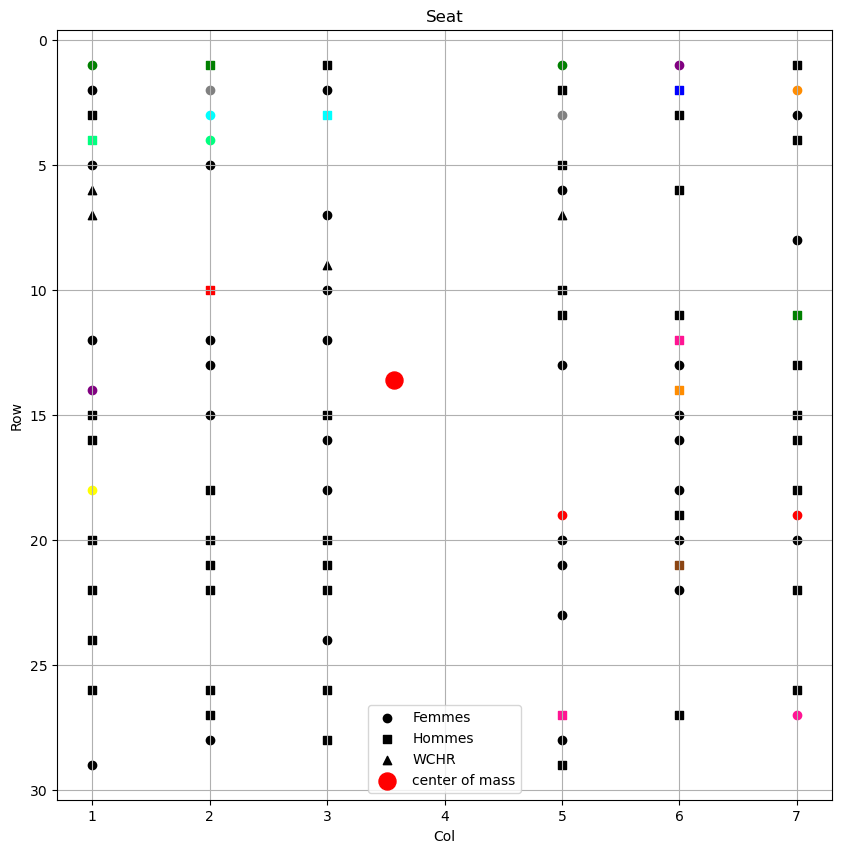

In [19]:
plot_seating(globals()[passengers_variable_name], globals()[seat_coords_variable_name], globals()[x_g_variable_name], globals()[y_g_variable_name])

Evaluation

In [20]:
print (groupe(1,globals()[passengers_variable_name]))

[1, 2, 3]


In [44]:
def metrique_retangule(passengers):
    satisfaction_scores = 0 
    group_scores = {}  

    for i in passengers:
        group = groupe(i, passengers)
        group_coords = [globals()[seat_coords_variable_name][idx - 1] for idx in group]

        min_x = min(coord[0] for coord in group_coords)
        max_x = max(coord[0] for coord in group_coords)


        min_y = min(coord[1] for coord in group_coords)
        max_y = max(coord[1] for coord in group_coords)
       
        y_distance = max_y - min_y
        x_distance = max_x - min_x

        if x_distance == len(group)  and y_distance == 0:
            #group_scores[i] = 5
            satisfaction_scores += 5 
        else:
            score = ponderation(x_distance, y_distance)
            #group_scores[i] = score
            satisfaction_scores += score

    return satisfaction_scores, group_scores


metrique_retangule(globals()[passengers_variable_name])

IndexError: list index out of range

In [41]:
def metrique_retangule_2(passengers):
    satisfaction_scores = 0 

    for i in passengers:
        group = groupe(i, passengers)
        group_coords = [globals()[seat_coords_variable_name][idx - 1] for idx in group]  

        
        min_x = min(coord[0] for coord in group_coords)
        max_x = max(coord[0] for coord in group_coords)


        min_y = min(coord[1] for coord in group_coords)
        max_y = max(coord[1] for coord in group_coords)

        
        x_distance = max_x - min_x
        y_distance = max_y - min_y

        if(x_distance == len(group) and y_distance == 0):
                satisfaction_scores += 5 
        else:
            satisfaction_scores += ponderation(x_distance, y_distance)

        return satisfaction_scores


In [42]:
metrique_retangule_2(globals()[passengers_variable_name])

2.0833333333333335

In [63]:
def metrique_groupe_stricte(S, Passengers, ns):
    sat={}
    
    group=group_dict(Passengers)
 
    for g in group:
        seats = [j for i in group[g] for j in range(1, ns + 1) if S[(i, j)].x]
        group_coord=seat_coordinates(seats)

        X=[]
        Y=[]
        for i in range (len(group[g])):
            X += [group_coord [i][0]]
            Y += [group_coord [i][1]]
            X.sort()
            Y.sort()

        if len(group[g]) == 1:
            sat[g] = 1

        #Groupe de 2 passagers : ils doivent être côte à côte. Satisfaction intermédiaire si séparés par allée centrale
        if len(group[g]) == 2:
            if Y[0] == Y[1]:
                if X[1] == X[0]+1:
                    sat[g] = 1
                elif (3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0

            else : 
                sat[g] = 0

        #Groupe de 3 : aligné sur le même rang. Satisfaction max si côtes à côtes, intermédiaire si séparés par allée centrale, nulle sinon
        elif len(group[g]) == 3:
            if Y[0] == Y[1] and Y[0] == Y[2]:
                if X[1] == X[0]+1 and X[2] == X[1]+1:
                    sat[g] = 1

                elif (X[1] == X[0]+1 or X[2] == X[1]+1) and(3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0
            else : 
                sat[g] = 0

        #Groupe de 4 à 6 personnes
        elif len(group[g]) <=6 :
            if all(y == Y[0] for y in Y):
                
                if X[len(group[g])-1]-X[0] == len(group):
                    sat[g]=1
                else:
                    sat[g]=1
            
            elif Y[1]==Y[0]+1:
                if (3 in X and 5 not in X) or (5 in X and 3 not in X):
                    sat[g]=1/2
                else:
                    sat[g]=0
            else :
                sat[g]=0   
                
        else:
            sat[g]=1

    return sat

In [64]:
#Retourne une note sur 1 par passager concernant l'objectif de transit
def metrique_transit_stricte(S, Passengers, ns):

    sat= {}
    
    ns = 29*7 
    
    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 1/2
                    elif y <= 10:
                        sat[i] = 1/3
                    else:
                        sat[i] =0
        else :
            sat[i]=1
            
    return  sat

In [73]:
def metrique_globale_stricte(S, Passengers, ns):
    sat={}
    moyenne=0
    sat_groupe=0
    sat_transit=0
    #Pour fusionner les notes des passagers au regard des deux fonctions objectif, on transforme les notes par groupe pour la fonction groupe en note par passager
    sat1={}
    s=metrique_groupe_stricte (S, Passengers, ns)
    group_dico=group_dict(Passengers)
    for g in group_dico:
        sat_groupe += s[g]
        passagers = group_dico[g]
        for i in passagers:
            sat1[i]=s[g]

    sat2=metrique_transit_stricte(S, Passengers, ns)

    for i in Passengers:
        sat[i]=(sat1[i] + sat2[i])/2
        moyenne += sat[i]
        sat_transit += sat2[i]
        

    moyenne = moyenne / len(Passengers)
    sat_groupe = sat_groupe / len(s)
    sat_transit =sat_transit / len(Passengers)
    # print (list(sat.values()))
    # m=min(list(sat.values()))
    # M=max(list(sat.values()))
    return moyenne, sat_transit, sat_groupe

In [76]:
moyenne, s_transit, s_groupe = metrique_globale_stricte(globals()[model_variable_name_S], globals()[passengers_variable_name], number_of_seats if selected_date != 'Nov7' else number_of_seats_Nov7)

# print ("Le pire niveau de satisfaction est de ", m*100, "%")
# print ("Le meilleur niveau de satisfaction est de ", M*100, "%")
print ("La satisfaction moyenne des passagers est de ", moyenne*100, "%")
print ("La satisfaction moyenne des passagers en transit est de ", s_transit)
print ("La satisfaction moyenne des groupes est de ",s_groupe)

La satisfaction moyenne des passagers est de  87.11340206185567 %
La satisfaction moyenne des passagers en transit est de  1.0
La satisfaction moyenne des groupes est de  0.8653846153846154
